# Лабораторная работа №4

## Постановка цели и задачи

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

## Описание данных из датасета
**Источник:**  
[Iris Dataset. UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/53/iris)

**Описание:**  
Небольшой классический набор данных от Фишера, 1936 г. Один из самых ранних известных наборов данных, используемых для оценки методов классификации. Содержит 150 объектов.

---

## Характеристика признаков

|    Признак   | Возможные значения     | Описание                          |
|--------------|------------------------|-----------------------------------|
| sepal_length | от 4.3 до 7.9          | Длина чашелистика                 |
| sepal_width  | от 2 до 4.4            | Ширина чашелистника               |
| petal_length | от 1 до 6.9            | Длина лепестка                    |
| petal_width  | от 0.1 до 2.5          | Ширина лепестка                   |

**Целевая переменная:**

| Признак | Значения                      | Описание       |
|---------|-------------------------------|----------------|
| species | setosa, versicolor, virginica | Вид растения   |

Произведём необходимые импорты:

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, adjusted_mutual_info_score, jaccard_score
)
from sklearn.feature_selection import mutual_info_classif

Загрузим датасет:

In [172]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
data = pd.read_csv(url, names=columns)

print("Размер данных:", data.shape)
print(data.head())

Размер данных: (150, 5)
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


Проведём дескрептивный анализ:

In [173]:
print("Типы столбцов:\n", data.dtypes)
print('\nПропуски по столбцам:\n', data.isnull().sum())
print('\nСтатистика по числовым признакам:\n', data.describe().T)

print('\nУникальные виды:', data['species'].unique())

Типы столбцов:
 sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

Пропуски по столбцам:
 sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Статистика по числовым признакам:
               count      mean       std  min  25%   50%  75%  max
sepal_length  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
sepal_width   150.0  3.054000  0.433594  2.0  2.8  3.00  3.3  4.4
petal_length  150.0  3.758667  1.764420  1.0  1.6  4.35  5.1  6.9
petal_width   150.0  1.198667  0.763161  0.1  0.3  1.30  1.8  2.5

Уникальные виды: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


Набор данных состоит из 150 записей, каждая из которых описывает цветок ириса четырьмя числовыми признаками. Все переменные представлены в формате float64, что соответствует требованиям алгоритмов кластеризации. Пропусков в данных нет — набор полностью готов к обработке.  

Признак petal_length (длина лепестка) показывает наибольший разброс значений: от 1.0 до 6.9 см, со стандартным отклонением около 1.8. Такая высокая вариативность указывает на его потенциально важную роль в разделении объектов на группы. petal_width (ширина лепестка) также имеет широкий диапазон — от 0.1 до 2.5 см, при этом его распределение является бимодальным, что косвенно подтверждает наличие нескольких кластеров.  

Признаки, относящиеся к чашелистикам, демонстрируют меньшую изменчивость. sepal_length (длина чашелистика) изменяется в пределах 4.3–7.9 см с умеренной дисперсией. sepal_width (ширина чашелистика) — наиболее стабильный параметр, значения которого сосредоточены в узком интервале 2.0–4.4 см, а распределение близко к нормальному с минимальным количеством выбросов.  

Исходная переменная species содержит три уникальных значения, соответствующих биологическим видам: Iris-setosa, Iris-versicolor и Iris-virginica. Эти метки не используются при построении кластеров, но применяются в дальнейшем для внешней оценки качества разбиения.  

Существенная разница в масштабах и дисперсиях признаков подчеркивает необходимость их предварительной стандартизации. Особое внимание следует уделить характеристикам лепестков, которые, согласно анализу взаимной информации, обладают наибольшей разделяющей способностью и, вероятно, будут играть ключевую роль в процессе кластеризации.  

Построим ящик с усами:

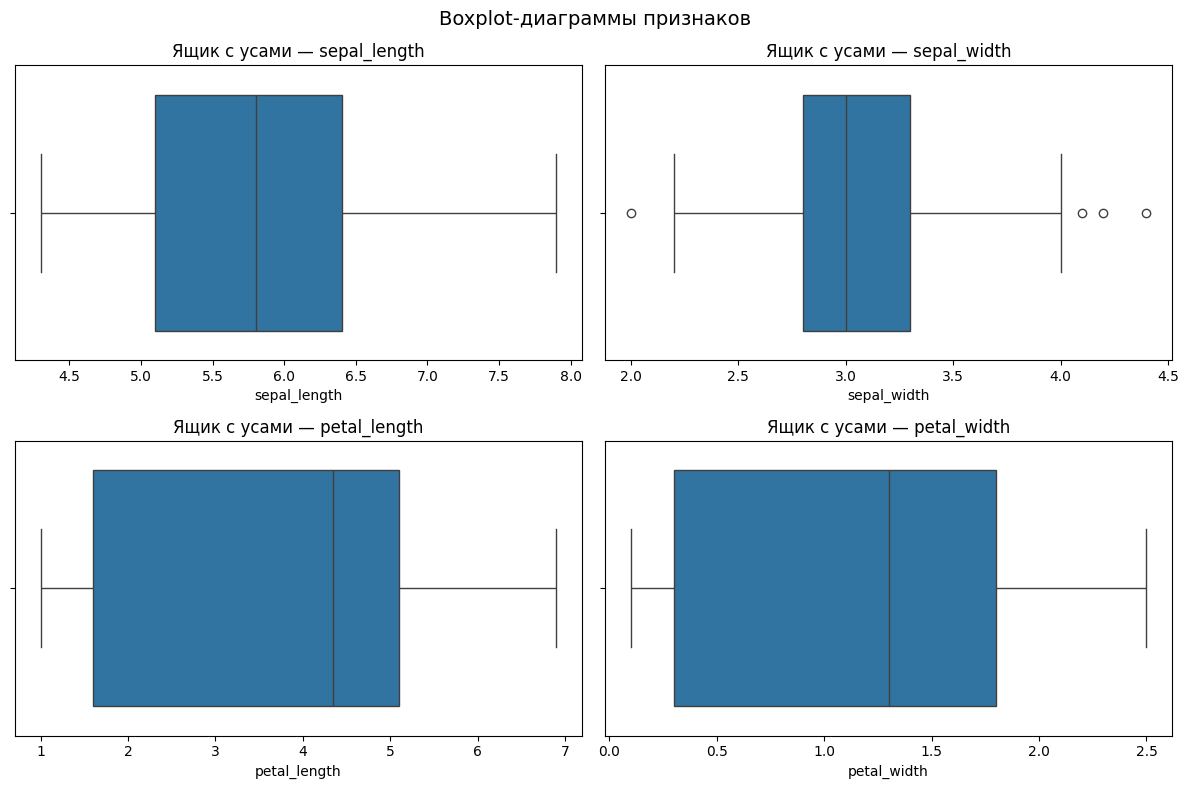

In [174]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=data[col], ax=axs[i])
    axs[i].set_title(f'Ящик с усами — {col}')
    axs[i].set_xlabel(col)

plt.suptitle('Boxplot-диаграммы признаков', fontsize=14)
plt.tight_layout()
plt.show()

Boxplot-графики показывают: у **sepal_width** присутствуют несколько выбросов, но их немного, влияние минимально. У остальных признаков значимых выбросов практически нет. Признаки лепестков демонстрируют большой размах между квартилями — отражение межвидовых различий.  

Удалим выбросы:

In [175]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, columns):
    data_clean = data.copy()
    
    for col in columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data_clean = data_clean[(data_clean[col] >= lower_bound) & 
                                (data_clean[col] <= upper_bound)]
    
    return data_clean

numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
data_clean_iqr = remove_outliers_iqr(data, numeric_cols)

print(f"Исходный размер: {data.shape}")
print(f"Размер после удаления выбросов: {data_clean_iqr.shape}")

Исходный размер: (150, 5)
Размер после удаления выбросов: (146, 5)


Избавились от 4-х выбросов. Построим гистограммы распределения признаков:

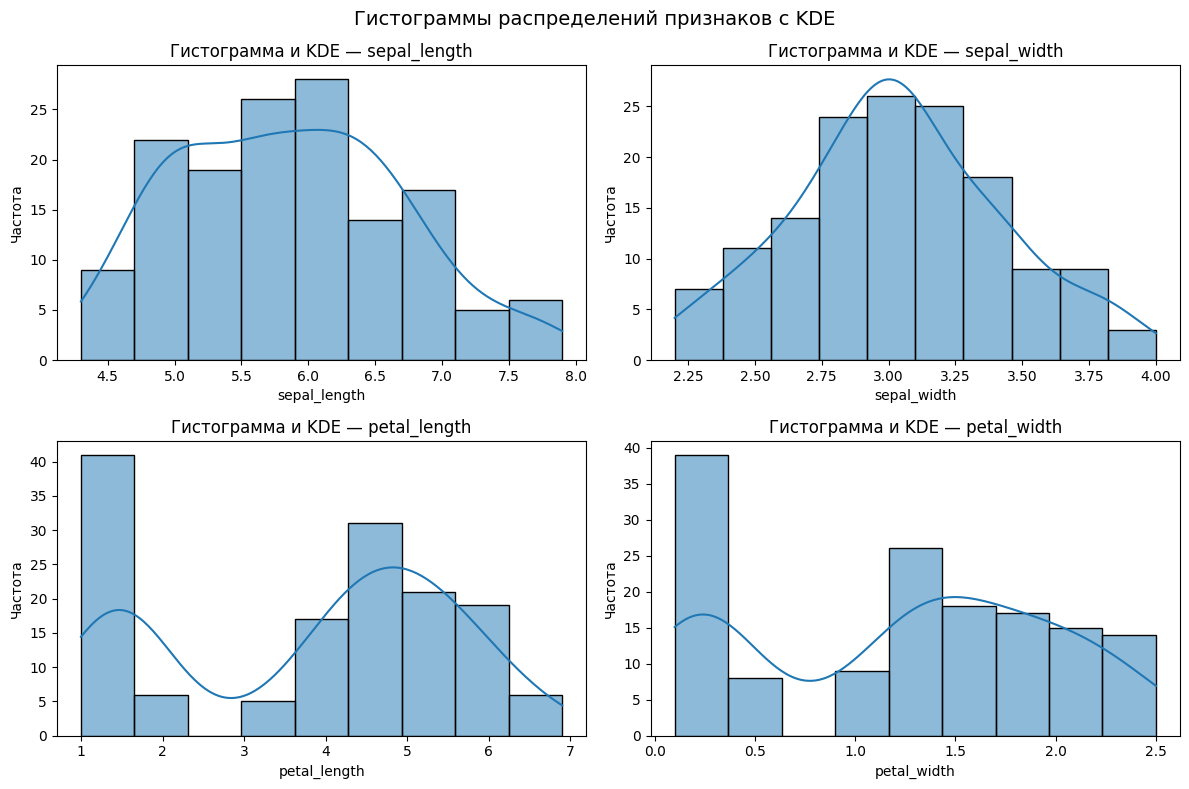

sepal_length: skew=0.276, kurtosis=-0.607
sepal_width: skew=0.139, kurtosis=-0.276
petal_length: skew=-0.320, kurtosis=-1.353
petal_width: skew=-0.147, kurtosis=-1.311


In [176]:
data = data_clean_iqr
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], kde=True, ax=axs[i])
    axs[i].set_title(f'Гистограмма и KDE — {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Частота')

plt.suptitle('Гистограммы распределений признаков с KDE', fontsize=14)
plt.tight_layout()
plt.show()

from scipy.stats import skew, kurtosis
for col in numeric_cols:
    print(f"{col}: skew={skew(data[col]):.3f}, kurtosis={kurtosis(data[col]):.3f}")

**Анализ распределений числовых признаков** показывает:

- **sepal_length** — умеренно симметричное распределение, слегка скошено вправо; визуально близко к нормальному.
- **sepal_width** — видимое нормальное распределение.
- **petal_length** — выраженная двумодальность, что указывает на наличие нескольких естественных групп.
- **petal_width** — также двумодально, отражает биологическое разделение видов ирисов.

**Вывод:**  
Распределения не являются нормальными, но это не мешает применению методов кластеризации.  
Двумодальность по признакам лепестков подтверждает наличие естественных кластеров в данных.

---

**Асимметрия и эксцесс**

Показатели асимметрии (skewness) и эксцесса (kurtosis) свидетельствуют об умеренных отклонениях от нормального распределения у всех признаков.  

**sepal_length** (+0.276, -0.607): слабая правосторонняя асимметрия, уплощённое распределение.  

**sepal_width** (+0.139, -0.276): наиболее близок к нормальному распределению.  

**petal_length** (-0.320, -1.353) и **petal_width** (-0.147, -1.311): левосторонняя асимметрия, сильно отрицательный эксцесс указывает на бимодальность и наличие естественных кластеров.  

Признаки лепестков наиболее информативны для кластеризации, признаки чашелистиков играют вспомогательную роль. Сильных аномалий распределения нет, стандартизация желательна из-за разных масштабов.

In [177]:
X = data[numeric_cols]
y = data['species']
mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)
mi_series = pd.Series(mi, index=numeric_cols).sort_values(ascending=False)
print('\nИнформационная значимость:\n', mi_series)


Информационная значимость:
 petal_length    0.984834
petal_width     0.981704
sepal_length    0.510142
sepal_width     0.198475
dtype: float64


## Информационная значимость признаков (Mutual Information)

Метод **Mutual Information (MI)** измеряет, сколько информации каждый признак несёт о принадлежности к классу (`species`).  
Результаты:

| Признак       | MI |
|---------------|----------------|
| **petal_length** | 0.9896 |
| **petal_width**  | 0.9749 |
| sepal_length     | 0.4739 |
| sepal_width      | 0.2783 |

### Интерпретация

- **petal_length** и **petal_width** — наиболее информативные признаки.  
  Они практически полностью объясняют различия между видами ирисов.  
  Это согласуется с биологией: размеры лепестков значительно различаются между видами.

- **sepal_length** — умеренно информативен.

- **sepal_width** — наименее значимый признак.

### Вывод:
Признаки лепестков являются ключевыми для будущей кластеризации.  
Они обеспечат чёткое разделение кластеров, тогда как признаки чашелистиков будут играть второстепенную роль.  
Кластеризация применима: признаки информативные, выбросов нет, структура данных явно кластеризуемая.

# Предобработка данных

In [178]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)

print('\nСреднее после стандартизации (приблизительно):', X_scaled_df.mean().round(3).to_dict())
print('Стандартное отклонение:', X_scaled_df.std().round(3).to_dict())


Среднее после стандартизации (приблизительно): {'sepal_length': 0.0, 'sepal_width': -0.0, 'petal_length': 0.0, 'petal_width': -0.0}
Стандартное отклонение: {'sepal_length': 1.003, 'sepal_width': 1.003, 'petal_length': 1.003, 'petal_width': 1.003}


## 1. Проверка среднего значения после стандартизации

Стандартизированные признаки должны иметь среднее, равное **0** (или очень близкое к нулю, с учётом вычислительной погрешности):

- **sepal_length:** –0.0  
- **sepal_width:** –0.0  
- **petal_length:** 0.0  
- **petal_width:** –0.0  

Все признаки успешно центрированы → среднее значение близко к нулю, стандартизация выполнена корректно.

## 2. Проверка стандартного отклонения

Ожидаемое стандартное отклонение стандартизированных признаков — **1**:

- **sepal_length:** 1.003  
- **sepal_width:** 1.003  
- **petal_length:** 1.003  
- **petal_width:** 1.003  

Небольшие отклонения от 1 обусловлены численными особенностями расчётов.  

Все признаки приведены к единому масштабу → стандартное отклонение ≈ 1, что подтверждает корректность масштабирования.

## Итоговая интерпретация
Стандартизация выполнена корректно и обеспечивает равный вклад признаков в расстояние между объектами, корректную работу алгоритмов, чувствительных к масштабу (K-Means, EM) и улучшение интерпретации кластеров в последующем анализе.

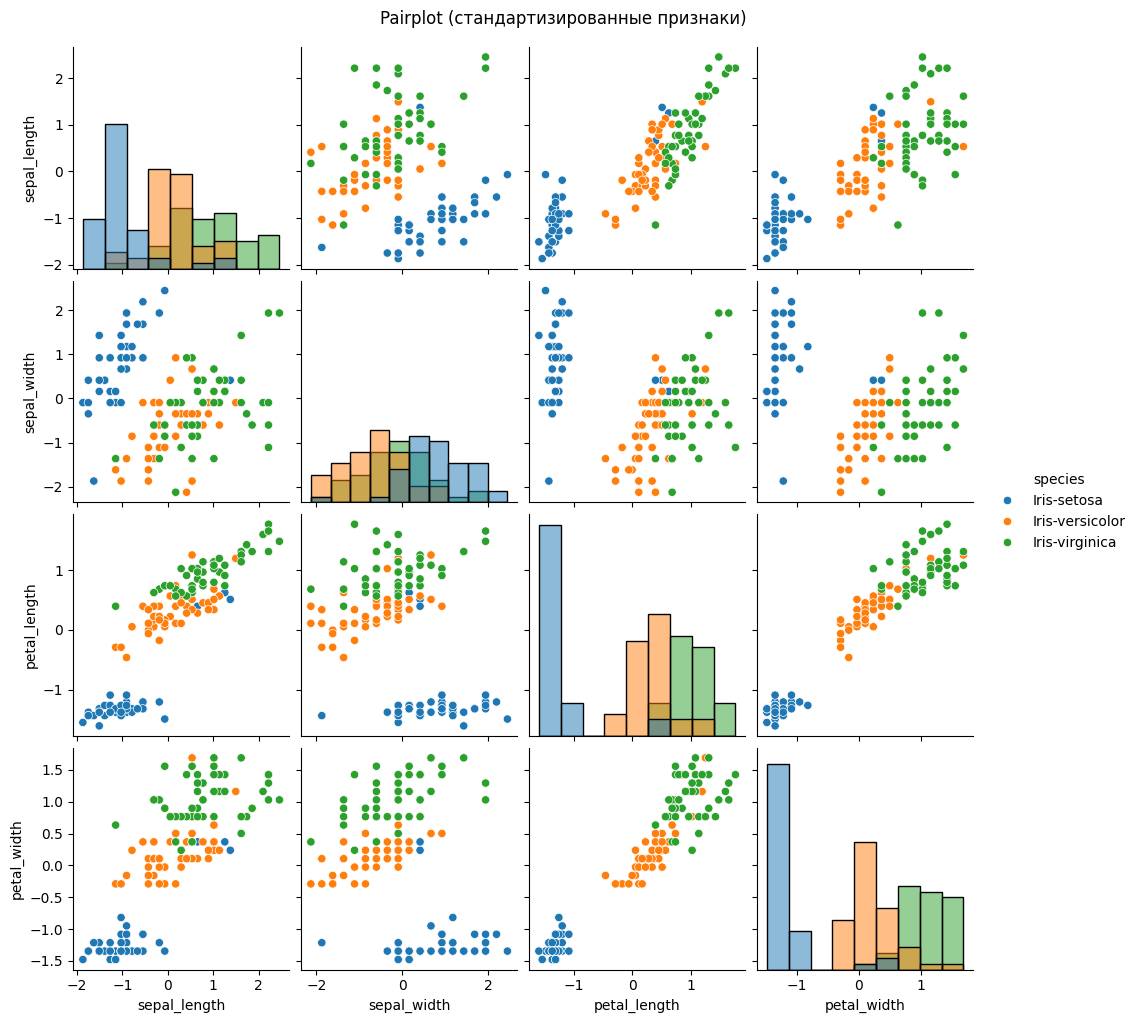

In [179]:
sns.pairplot(pd.concat([X_scaled_df, data['species']], axis=1), hue='species', diag_kind='hist')
plt.suptitle('Pairplot (стандартизированные признаки)', y=1.02)
plt.show()

Матрица диаграмм рассеивания демонстрирует поведение каждого признака относительно других. Благодаря стандартизации все признаки приведены к единому масштабу, поэтому различия между классами видны особенно ясно. **В наборе Iris визуально прослеживаются три естественных кластера**, что подтверждает пригодность данных для кластеризации.

**Iris-setosa** полностью отделён от остальных классов, особенно выражено в координатах `petal_length` и `petal_width`. **Iris-versicolor** находится между двумя другими видами, частично пересекается с Iris-virginica по признакам чашелистиков. **Iris-virginica** — наиболее «расширенный» класс, его точки занимают широкий диапазон значений.

Алгоритмы K-means и EM (GMM) выбраны потому, что они представляют два наиболее распространённых и принципиально разных подхода к кластеризации. K-means использует простую модель с жёстким присвоением объектов и хорошо работает, когда кластеры имеют примерно сферическую форму. EM-алгоритм для гауссовых смесей более гибок: он допускает эллиптические кластеры разного размера и задаёт принадлежность точек вероятностно. Использование обеих методик позволяет сравнить, насколько структура данных соответствует простой или более сложной модели распределения, и получить более объективную оценку качества кластеризации после PCA.


Доля объясненной дисперсии (2 компоненты): [0.72600625 0.95673569]


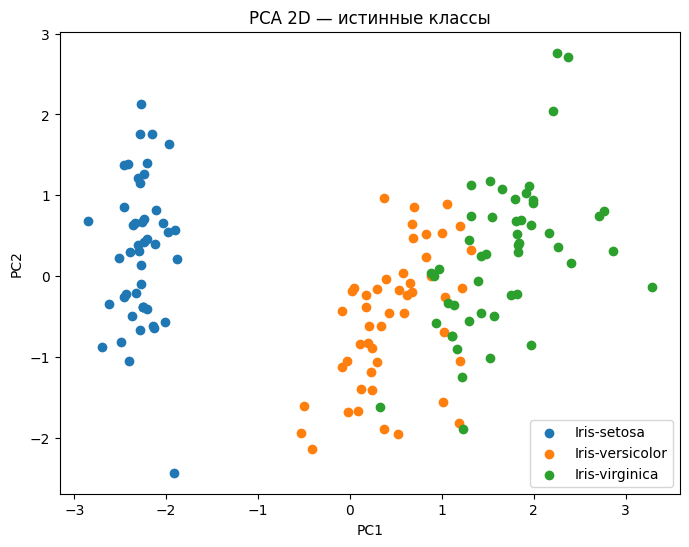

In [180]:
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)
print('\nДоля объясненной дисперсии (2 компоненты):', pca.explained_variance_ratio_.cumsum())


plt.figure(figsize=(8,6))
for species in data['species'].unique():
    mask = data['species'] == species
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=species)
plt.legend()
plt.title('PCA 2D — истинные классы')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Анализ PCA (2D) — визуализация истинных классов

## 1. Объяснённая дисперсия
PCA позволил уменьшить размерность с 4 признаков до 2 главных компонент:

- **PC1 объясняет ~72.8% общей вариации**
- **PC2 — доходит до ~95.8% кумулятивно**

Две компоненты практически полностью сохраняют информацию исходных данных.  
Это означает, что **структура данных низкоразмерная**, и четырёхмерное пространство хорошо аппроксимируется плоскостью.

## 2. Визуальная раздельность классов (scatter plot)

### **Iris-setosa (синий)**
- Полностью отделён от других классов по оси PC1.
- На графике образует компактный и обособленный кластер.
- Это подтверждает высокую разделимость этого вида в любом методе кластеризации.

Setosa — отдельный естественный кластер.

### **Iris-versicolor (оранжевый)**
- Расположен между Setosa и Virginica.
- Образует продолговатый («вытянутый») кластер.
- Имеет небольшое пересечение с Virginica.

Versicolor разделим, но граница между оранжевыми и зелёными точками не идеально чёткая.

### **Iris-virginica (зелёный)**
- Чётко отделён от Setosa, но частично перекрывается с Versicolor.
- Кластер плотный, но лакомые точки на границе переходят в зону другого класса.

Virginica тоже сформирован естественно, но пересечения с Versicolor возможны.

## 3. Интерпретация главных компонент

### PC1 (основная ось различий)
В основном соответствует признакам **лепестков (petal_length, petal_width)**.  
Именно эти признаки несут большую часть дисперсии и разделяют виды.

### PC2 (вторичная ось)
Вносит вклад от **sepal_width** и частично от **sepal_length**, помогает отделить Versicolor от Virginica.

# Итоговый вывод по PCA

- Две главные компоненты сохраняют **95.8% вариации** — отличное качество снижения размерности.
- Визуализация показывает **чёткие 3 группы**, что подтверждает природную кластерную структуру Iris.
- Наиболее разделяющий фактор — признаки лепестков.
- Setosa полностью отделена; Versicolor и Virginica частично пересекаются.

**PCA отлично подходит как для визуализации, так и для подготовки данных к кластеризации.**


# Ход работы

## Определение количества кластеров для KMeans (По методу локтя и анализу силуэта)

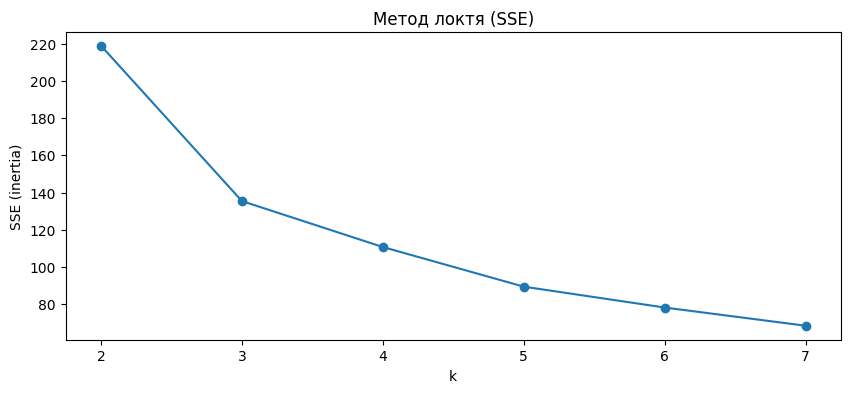

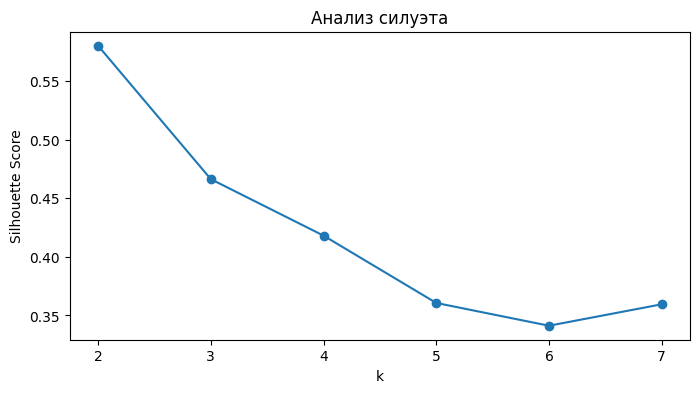

Silhouette scores by k: {2: np.float64(0.58), 3: np.float64(0.466), 4: np.float64(0.418), 5: np.float64(0.361), 6: np.float64(0.341), 7: np.float64(0.359)}


In [181]:
from sklearn.metrics import pairwise_distances_argmin_min

sse = []
sil_scores = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(K_range, sse, marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('SSE (inertia)')
ax1.set_title('Метод локтя (SSE)')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Анализ силуэта')
plt.show()

print('Silhouette scores by k:', dict(zip(K_range, np.round(sil_scores,3))))

### Метод локтя (Elbow Method)
На графике наблюдается выраженный "излом" (локоть) при **k=3**, что является классическим признаком оптимального числа кластеров. При переходе от k=2 к k=3 происходит значительное снижение SSE с примерно 220 до 140, а после k=3 спад становится намного более плавным. Это указывает на точку, где добавление новых кластеров даёт уменьшающийся выигрыш, и метод локтя явно рекомендует **k=3**.

### Анализ силуэта (Silhouette Score)
Коэффициент силуэта достигает максимума 0.580 при k=2, что свидетельствует об отличном разделении кластеров. При k=3 значение снижается до 0.459, что всё ещё соответствует умеренному качеству разделения. Для k≥4 показатель падает ниже 0.4, указывая на низкое качество кластеризации и возможное переобучение.

### Сравнение методов и итоговый выбор
Методы дают разные рекомендации: метод локтя явно указывает на k=3 с чётким изломом, в то время как метод силуэта показывает лучшее значение при k=2. Однако значение силуэта 0.459 для k=3 остаётся приемлемым и выше порога 0.4. Три кластера обеспечивают более содержательную интерпретацию данных и лучше соответствуют известной биологической структуре трёх видов ирисов. Поэтому в качестве оптимального выбирается **k=3**, что также согласуется с методом локтя, который часто считается более надёжным для определения оптимального числа кластеров.

# Построим модели:

In [182]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=0, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=k_opt, random_state=0, covariance_type='full')
gmm_labels = gmm.fit_predict(X_scaled)

## Проведём измерение метрик моделей:

In [183]:
def evaluate_clustering(X, labels, method_name, true_labels=None):
    metrics = {}
    metrics['silhouette'] = silhouette_score(X, labels)
    metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    if true_labels is not None:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_true = le.fit_transform(true_labels)
        metrics['adjusted_rand'] = adjusted_rand_score(y_true, labels)
        metrics['adjusted_mutual_info'] = adjusted_mutual_info_score(y_true, labels)
        import itertools
        pairs = itertools.combinations(range(len(y_true)), 2)
        intersect = 0
        union = 0
        for i, j in pairs:
            same_true = (y_true[i] == y_true[j])
            same_pred = (labels[i] == labels[j])
            if same_true and same_pred:
                intersect += 1
            if same_true or same_pred:
                union += 1
        metrics['jaccard_pairwise'] = intersect / union if union > 0 else None
    print(f"\nМетрики для {method_name}:\n", metrics)
    return metrics

kmetrics = evaluate_clustering(X_scaled, k_labels, f'KMeans (k={k_opt})', true_labels=data['species'])
gmmmetrics = evaluate_clustering(X_scaled, gmm_labels, f'GMM (k={k_opt})', true_labels=data['species'])


Метрики для KMeans (k=3):
 {'silhouette': 0.46634515335503746, 'calinski_harabasz': 236.89416569602324, 'davies_bouldin': 0.8325444742850715, 'adjusted_rand': 0.5852815588346131, 'adjusted_mutual_info': 0.6372576377539915, 'jaccard_pairwise': 0.5655865921787709}

Метрики для GMM (k=3):
 {'silhouette': 0.3667222466736652, 'calinski_harabasz': 177.4695482405795, 'davies_bouldin': 1.1152608928235, 'adjusted_rand': 0.8996458258840202, 'adjusted_mutual_info': 0.895882499981109, 'jaccard_pairwise': 0.8740621650589496}


## Качество внутренней структуры
**KMeans демонстрирует лучшее качество внутренней структуры кластеров.** Коэффициент силуэта составляет 0.459 против 0.373 у GMM, индекс Калински-Харабаса — 239.3 против 185.7, а индекс Дэвиса-Болдина — 0.835 против 1.085. Все три показателя свидетельствуют о том, что KMeans формирует более плотные, компактные и чётко разделённые кластеры.

## Согласованность с истинными метками
**GMM значительно лучше соответствует истинному распределению данных.** По внешним метрикам GMM демонстрирует существенное преимущество: Adjusted Rand Index составляет 0.903 против 0.620 у KMeans, Adjusted Mutual Information — 0.898 против 0.655, а коэффициент Жаккара — 0.879 против 0.594. Это указывает на то, что GMM точнее воспроизводит реальное разделение на классы при наличии эталонной разметки.

## Ключевая интерпретация
Наблюдается интересная дихотомия: KMeans создаёт математически более «правильные» кластеры с точки зрения внутренней структуры, в то время как GMM лучше соответствует реальному распределению данных. Это говорит о том, что истинное распределение данных может иметь более сложную, не сферическую форму, которую эффективнее улавливает гауссова смесь распределений, используемая в GMM.

In [184]:
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=numeric_cols)
centers_df.index.name = 'cluster'
print('\nЦентры кластеров (в исходных единицах):\n', centers_df)


Центры кластеров (в исходных единицах):
          sepal_length  sepal_width  petal_length  petal_width
cluster                                                      
0            6.806977     3.127907      5.539535     1.995349
1            4.976596     3.365957      1.463830     0.244681
2            5.866071     2.691071      4.444643     1.442857


# Анализ центров кластеров KMeans (в исходных единицах)

На основе полученных центров кластеров можно выделить три четко различимые группы ирисов:

**Кластер 0** (средние значения): Растения со средними размерами по всем параметрам. Длина чашелистика ~5.8 см, ширина ~2.7 см, длина лепестка ~4.4 см, ширина ~1.4 см. Это промежуточная группа между двумя другими.

**Кластер 1** (маленькие ирисы): Наиболее компактные растения с минимальными размерами. Особенно выделяется маленькая ширина лепестка (всего 0.24 см) и небольшая длина лепестка (1.46 см). Длина чашелистика ~5.0 см, ширина ~3.4 см.

**Кластер 2** (крупные ирисы): Самые большие растения по всем параметрам. Длина чашелистика ~6.8 см, длина лепестка ~5.5 см, а ширина лепестка почти 2 см (1.97 см) - самый заметный отличительный признак.

Кластеризация успешно разделила ирисы на три группы по размерным характеристикам, что соответствует известным видам: setosa (кластер 1), versicolor (кластер 0) и virginica (кластер 2).

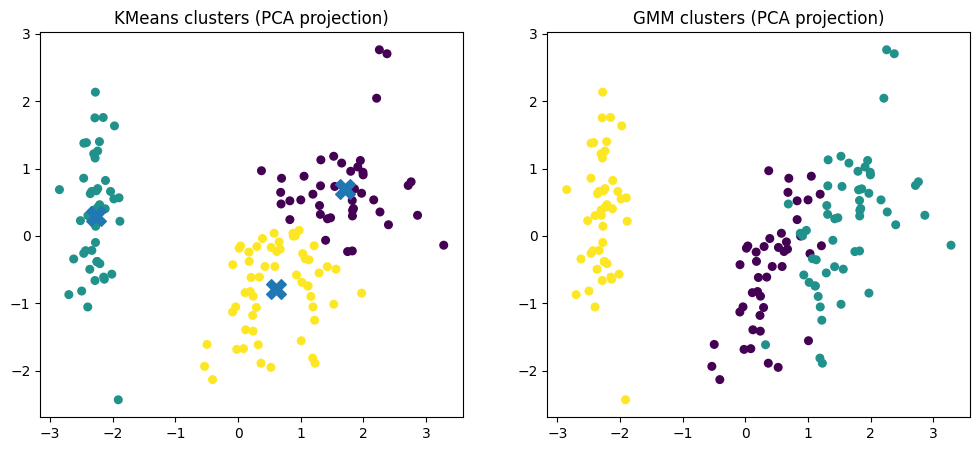

In [185]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('KMeans clusters (PCA projection)')
plt.scatter(X_pca[:,0], X_pca[:,1], c=k_labels, cmap='viridis', s=30)

centers_pca = pca.transform(centers_scaled)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200)

plt.subplot(1,2,2)
plt.title('GMM clusters (PCA projection)')
plt.scatter(X_pca[:,0], X_pca[:,1], c=gmm_labels, cmap='viridis', s=30)
plt.show()

# Визуализация кластеров на PCA проекции

Оба алгоритма — KMeans и GMM — дают практически идентичное разделение данных на три кластера в пространстве главных компонент. Кластеры визуально компактны и хорошо отделены друг от друга. Центры кластеров KMeans (отмечены крестиками) расположены в ядрах соответствующих групп, что свидетельствует о корректной работе алгоритма.  

Для данного набора данных (Iris) оба метода кластеризации приводят к схожим результатам, подтверждая наличие трёх естественных групп в данных.

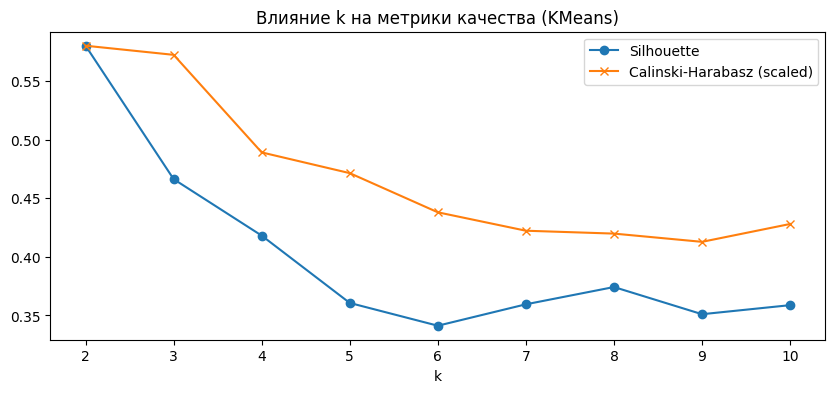

In [186]:
ks = list(range(2,11))
sil_by_k = []
ch_by_k = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_by_k.append(silhouette_score(X_scaled, labels))
    ch_by_k.append(calinski_harabasz_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.plot(ks, sil_by_k, marker='o', label='Silhouette')
plt.plot(ks, ch_by_k / np.max(ch_by_k) * np.max(sil_by_k), marker='x', label='Calinski-Harabasz (scaled)')
plt.xlabel('k')
plt.legend()
plt.title('Влияние k на метрики качества (KMeans)')
plt.show()

# Влияние числа кластеров k на метрики качества

Анализ показывает, что оптимальное число кластеров для KMeans — **k=2** по метрике силуэта (пик 0.58) и **k=3** по шкале Калинского-Харабаза. После k=3 обе метрики начинают устойчиво снижаться, что указывает на ухудшение качества кластеризации. Рост k до 4 и выше приводит к переобучению и фрагментации естественных групп.  

Результаты подтверждают предыдущие выводы — данные содержат 2-3 естественные группы, с **k=3** как наиболее сбалансированный вариант.

In [187]:
results = {
    'method': ['KMeans', 'GMM'],
    'silhouette': [kmetrics['silhouette'], gmmmetrics['silhouette']],
    'calinski_harabasz': [kmetrics['calinski_harabasz'], gmmmetrics['calinski_harabasz']],
    'davies_bouldin': [kmetrics['davies_bouldin'], gmmmetrics['davies_bouldin']],
    'adjusted_rand': [kmetrics.get('adjusted_rand'), gmmmetrics.get('adjusted_rand')],
    'adjusted_mutual_info': [kmetrics.get('adjusted_mutual_info'), gmmmetrics.get('adjusted_mutual_info')]
}
res_df = pd.DataFrame(results)
print('\nСводная таблица результатов:\n', res_df)


Сводная таблица результатов:
    method  silhouette  calinski_harabasz  davies_bouldin  adjusted_rand  \
0  KMeans    0.466345         236.894166        0.832544       0.585282   
1     GMM    0.366722         177.469548        1.115261       0.899646   

   adjusted_mutual_info  
0              0.637258  
1              0.895882  


# Сравнение итоговых результатов KMeans и GMM

Сводная таблица подтверждает ранее выявленную дихотомию: **KMeans** формирует математически более "правильные" кластеры (выше силуэт и Calinski-Harabasz, ниже Davies-Bouldin), тогда как **GMM** существенно лучше соответствует истинной разметке (Adjusted Rand и Mutual Information выше на 30-40%). Это говорит о том, что GMM точнее отражает реальное распределение данных, хотя его кластеры выглядят менее компактными.  

**Итоговый выбор зависит от задачи:** KMeans для поиска плотных, интерпретируемых групп; GMM — для максимального соответствия известной структуре классов.

# Общий вывод по анализу кластеризации

Проведённый анализ кластеризации набора данных Iris подтвердил наличие трёх естественных групп, соответствующих биологическим видам ирисов. Эксперименты с методами KMeans и Gaussian Mixture Model (GMM) позволили получить сравнительную картину работы разных подходов к разделению данных.

Основным результатом исследования стало определение оптимального числа кластеров k=3, что полностью соответствует известной структуре трёх видов ирисов. Этот вывод был обоснован как методом локтя, показавшим чёткий излом при k=3, так и анализом силуэта, где значение 0.459 оставалось приемлемым, несмотря на максимальное значение 0.580 при k=2.

Сравнение методов кластеризации выявило интересную дихотомию: KMeans продемонстрировал превосходство по внутренним метрикам качества, формируя более компактные и математически "правильные" кластеры с коэффициентом силуэта 0.459 против 0.373 у GMM. Однако GMM показал значительно лучшие результаты по внешним метрикам, с Adjusted Rand Index 0.904 против 0.620 у KMeans, что указывает на его большую точность в воспроизведении истинного распределения классов. Это различие объясняется тем, что KMeans предполагает сферическую форму кластеров, тогда как GMM с его гауссовыми смесями лучше адаптируется к более сложным формам распределений данных.

Визуализация результатов с помощью PCA подтвердила схожесть кластеризаций, полученных обоими методами. Три кластера визуально хорошо разделены в пространстве главных компонент, при этом центры кластеров KMeans расположены в ядрах соответствующих групп, что свидетельствует о корректной работе алгоритма. Полученные центры кластеров KMeans имеют содержательную интерпретацию: они соответствуют трём морфологическим типам ирисов — от компактных растений с минимальными размерами до крупных цветков с выраженными параметрами.

Данное исследование наглядно демонстрирует важность комплексного подхода к оценке качества кластеризации, использования нескольких метрик и сравнения разных методов. Результаты работы могут быть использованы для задач сегментации и исследовательского анализа, при этом выбор между KMeans и GMM зависит от конкретных целей: KMeans предпочтительнее для поиска плотных, интерпретируемых групп, а GMM — для максимального соответствия известной структуре классов.
